First Import the data

In [1]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
#df = pd.read_csv()
#data = np.loadtxt('/Users/wangsiyuan/Desktop/GSFM/GSFM_GP/FF48.csv', delimiter=',')
df = pd.read_csv('/Users/wangsiyuan/Desktop/GSFM/GSFM_GP/48_Industry_Portfolios_Daily_Clean.csv')
#df = df.rename(columns={'Unnamed: 0': 'month'})
#df['month'] = df['month'].astype(str)

Since the purpose is computing the weight situation in each month and see the rebalancing situation, each months' weight shoule be derived.
Thus, the below function is used for extracting:
    X: a month data for different industries by the given month
    cov: cov function 

In [58]:
df = df.rename(columns={'Average Value Weighted Returns -- Daily': 'date'})

In [59]:
df = df.reset_index(drop=True)
#df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')
#df.dtypes
df['date'] = df['date'].astype(float)
df_filtered = df.loc[df['date'] >= 19921231]
 #and df['date'] <= 19941231
df_filtered = df_filtered.loc[df_filtered['date'] <= 20141231]
df = df_filtered.reset_index(drop=True)
df = df/100

## Function to create a cov matrix and return in the past 250 days

In [60]:
#start is the initial index
def setup_data(df, start):
    #X is the return matrix, Sigma is the matrix of portfolio variance in the past 250 days
    #start_index = df.loc[df['date'] == start].index.tolist()
    #start = start_index[0]
    end = start + 249
    X = df.loc[start:end,:] 
    x = df.iloc[:,2:51]
    #used for compute the cov matrix, which is the return of the assets (excluding date)
    mu = X.iloc[:,2:51] 
    #['date'] >= start) & (['date'] <= (end)
    cov = mu.cov()
    #slicing the next 21 days and accumulate the returns for the next 21 days
    s_hold = end + 1
    e_hold = s_hold + 20
    #slice the desired data frame first, then sum over the columns 
    totalRet_21 = np.array(x.loc[s_hold:e_hold,:].sum().tolist())
    return X, mu, cov,totalRet_21

#第一种方法，slicing based on the starting date
def setup_data(df, start):
    #X is the return matrix, Sigma is the matrix of portfolio variance in the past 250 days
    start_index = df.loc[df['date'] == start].index.tolist()
    start = start_index[0]
    end = start + 249
    X = df.loc[start:end,:] 
    #used for compute the cov matrix, which is the return of the assets (excluding date)
    mu = X.iloc[:,2:51] 
    #['date'] >= start) & (['date'] <= (end)
    cov = mu.cov()
    return X, mu, cov

In [76]:
X, mu, cov, totalRet_21= setup_data(df, 0)
mu 
#n = len(mu[0,:])
#np.shape(mu)[1]
totalRet_21.shape
#cov
#print(np.shape(cov))

(48,)

# Function to compute ideal weight in the next 21 days, NV1C

In [161]:
def weight(df,start):
    X, mu, cov,totalRet_21 = setup_data(df, start)
    
    # Define the number of assets in the portfolio
    n = np.shape(mu)[1]
    
    # Define the optimization variables
    w = cp.Variable(n)

    # Define the objective function
    objective = cp.Minimize(cp.quad_form(w, cov))
    # Define the constraints
    
    # for the level one NV1C constrain
    # Define the NV1C constraint, with max sum of weight 1.2, no short posistion
    constraints = [cp.sum(w) == 4,
                  w>=0]
                   #w[0:5]>=0.1]
        #cp.sum(w) == 2]
    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    # Print the results
    #print("Optimal portfolio:")
    #for i in range(n):
        #print("Asset ", i+1, ": ", w.value[i])
    #print("Expected return: ", mu.T @ w.value)
    #print("Risk (standard deviation): ", cp.sqrt(w.T @ Sigma @ w).value)
    return w.value

In [162]:
start = 0
w = weight(df,0)
b = sum(w)
b
#weight shape(48,0), same as return 


4.000000019137595

##Test cell

start  = 0
np.shape(weight(df,start))
print(np.shape(weight(df,start)))
weight(df,start)
#print(weight(df)[0])

'''' an alternative of NV1C
Define the NV1C constraint (lower boundary, meaning how many capital reserved for each assets)
    A = np.random.rand(5, n) # constraint coefficients
    b = np.random.rand(5) # constraint bounds
    constraints = [A @ w >= b]

# A Function to compute the weight in the whole time period

def weight_NV1C():
    df_weight = []
    for start in np.arange(0,len(df),21):
        wi = weight(df).reshape(-1,1)
        df_weight = np.concatenate((df_weight,wi),axis = 0)
    return df_weight #which is the data frame containing the whole desired period's weight for 48 assets

def weight_NV1C():
    #df_weight = np.zeros((1,48))
    for start in np.arange(0,len(df),21):
        wi = weight(df,start).reshape(-1,1).T
        
        #df_weight = np.row_stack((df_weight,wi))
    #df_weight = df_weight[1:(len(df_weight)+1),:]
    print(wi) #which is the data frame containing the whole desired period's weight for 48 assets

# Function to compute expected return for the next 21 days with calculated weight

In [145]:
def expected_return(df,start):
    X, mu, cov,totalRet_21 = setup_data(df, start)
    #w is the weight turned from the last period
    w = weight(df,start)
    exp_return = np.dot(totalRet_21,w)
    return exp_return

In [146]:
exp_return = expected_return(df,0)
print(expected_return)

<function expected_return at 0x7ff05b3eb310>


# Expected return over the whole period

In [163]:
arr = np.arange(0,(len(df)-250-21)+1,21)
#np.insert(a,0,0)
#arr = np.delete(arr,-1)
All_return = []
for start in arr:
    r = expected_return(df,start)
    #print(wi)
    All_return = pd.DataFrame(np.append(All_return,r))

    

In [164]:
value = np.arange(0,len(All_return),1)
    #len(value)
All_return.insert(loc=0, column='Period', value=value)
All_return.rename(columns={0: 'Expected Return'})

,Period,Expected Return
0,0,-0.025956
1,1,-0.067205
2,2,0.046618
3,3,-0.145028
4,4,-0.016097
...,...,...
247,247,0.191234
248,248,-0.082247
249,249,0.143626
250,250,0.116759


# plot the expected return over time

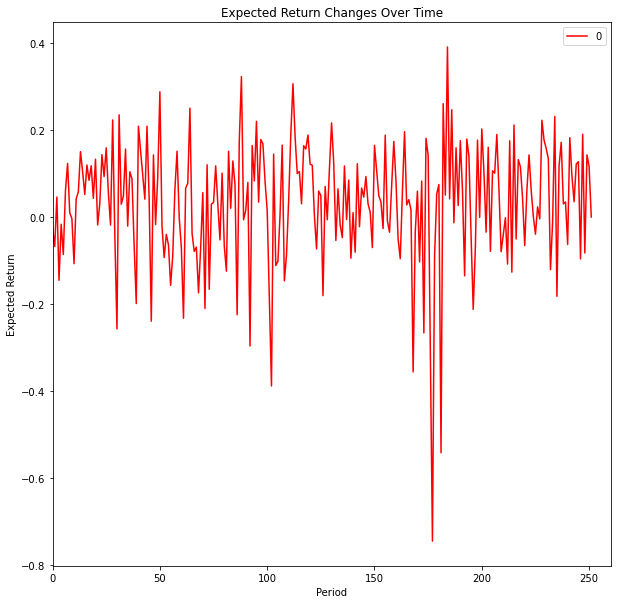

In [165]:
# set the 'Period' column as the index
All_return = All_return.set_index('Period')

# plot all columns at once
p = All_return.plot(figsize=(10, 10),label='NV1C',color='red')
#p.set_ylim([0, 1.2])
p.set_xlim([0, 260])
# set the x-axis label
plt.xlabel('Period')

# set the y-axis label
plt.ylabel('Expected Return')

# set the title of the graph
plt.title('Expected Return Changes Over Time')

# show the graph
plt.show()

## weight for the 48 assets in the columns and weight changes in the rows in the 252 periods

In [166]:
arr = np.arange(0,(len(df)-250-21)+1,21)
#np.insert(a,0,0)
#arr = np.delete(arr,-1)
df_weight=[]
for start in arr:
    wi = weight(df,start).reshape(-1,1).T
    #print(wi)
    df_weight = np.append(df_weight,wi)
#wi
#print(np.shape(df_weight))


In [167]:
df_weight = df_weight.reshape(252,48)
df_weight[10]

array([-2.55017762e-17,  2.67874924e-01, -1.37022083e-16,  1.91016616e-01,
        1.17441922e-16, -5.32514580e-18, -1.69289108e-16,  2.13591542e-01,
       -6.95206883e-18,  3.28269413e-01, -2.34131056e-16, -1.37670052e-16,
        4.39198380e-01, -2.88593928e-17, -4.99101999e-18,  1.62302011e-01,
       -9.34929324e-18,  2.33815223e-18, -1.34998676e-16, -1.86059534e-16,
       -7.24911250e-17,  3.74010561e-02, -7.09482694e-17,  7.68075772e-04,
       -2.81064903e-16, -3.08193229e-17,  3.15040165e-01,  4.85822347e-17,
        5.57185346e-03,  5.00102991e-01,  1.73680099e-01, -2.74510975e-18,
       -9.06342859e-19, -6.34078055e-17, -8.60336191e-17, -2.64391376e-16,
       -7.53541744e-17, -3.75593976e-17,  9.67687541e-03, -2.38427460e-17,
       -2.89252513e-17, -6.68162714e-18, -1.96721852e-17, -2.71578912e-16,
        6.70075969e-01,  6.85430029e-01, -3.01027582e-16,  8.58088741e-17])

In [136]:
df.shape

(5542, 50)

# Variance for the whole period

# start is the initial index
def setup_data(df, start):
    #X is the return matrix, Sigma is the matrix of portfolio variance in the past 250 days
    #start_index = df.loc[df['date'] == start].index.tolist()
    #start = start_index[0]
    end = start + 249
    X = df.loc[start:end,:] 
    x = df.iloc[:,2:51]
    #used for compute the cov matrix, which is the return of the assets (excluding date)
    mu = X.iloc[:,2:51] 
    #['date'] >= start) & (['date'] <= (end)
    cov = mu.cov()
    #slicing the next 21 days and accumulate the returns for the next 21 days
    s_hold = end + 1
    e_hold = s_hold + 20
    #slice the desired data frame first, then sum over the columns 
    totalRet_21 = np.array(x.loc[s_hold:e_hold,:].sum().tolist())
    return X, mu, cov,totalRet_21

In [168]:
#frist one period of weight:
arr = np.arange(0,(len(df)-250-21)+1,21)

variance_pre = []
for start in arr:
    w_one = weight(df,start) #weight for one period
    X, mu, cov,totalRet_21 = setup_data(df, start)
    intme = np.dot(w_one.T,cov)
    var = np.dot(intme,w_one)
    variance_pre = np.append(variance_pre,var)
variance_pre.T

array([0.00021421, 0.00020638, 0.00020745, 0.00019778, 0.00026412,
       0.00027627, 0.0002895 , 0.0002829 , 0.00028192, 0.00027491,
       0.00028157, 0.00028871, 0.00030439, 0.00030553, 0.00028254,
       0.00027888, 0.00020587, 0.00019963, 0.00018906, 0.00020006,
       0.00018593, 0.00017879, 0.00016297, 0.00015505, 0.00015935,
       0.00017005, 0.00018074, 0.00022274, 0.00023687, 0.00025217,
       0.00024405, 0.00029849, 0.0003309 , 0.00033945, 0.00032907,
       0.00032663, 0.00034764, 0.00033925, 0.00033681, 0.00030472,
       0.00032346, 0.00034809, 0.00036384, 0.00030652, 0.00031343,
       0.00032121, 0.00032575, 0.00046962, 0.0004679 , 0.00049075,
       0.0004899 , 0.00048584, 0.00045944, 0.00045229, 0.00048303,
       0.00048419, 0.00058924, 0.00068929, 0.00077073, 0.00067055,
       0.00067816, 0.00066478, 0.0007098 , 0.00074899, 0.00079812,
       0.0008144 , 0.00080805, 0.00080027, 0.00071621, 0.00058593,
       0.00052349, 0.00051401, 0.00049239, 0.00057389, 0.00059

In [169]:
var = np.sum(variance_pre)/len(variance_pre)
var#0.000462

0.0008223913269902531

# rf = [0.02 for i in range(len(df))]
len(rf)
rf = [0.02 for i in range()]
sharp_ratio = []

In [170]:
#set up vetor of 1*48 with default risk free rate 0.02
arr = np.arange(0,(len(df)-250-21)+1,21)
rf = 0.02
mean = []
for start in arr:
    X, mu, cov,totalRet_21 = setup_data(df, start)
    mean_21r = sum(totalRet_21/21)
    mean = np.append(mean,mean_21r)
    #f = mean_21r - rf
    #intem = np.append(intem,f)
sharp_ratio = []
#for i in np.arange(252):
shar = (mean - 0.02)/ variance_pre
    #sharp_ratio = np.append(sharp_ratio,shar)
    
sharp = np.sum(shar)/len(shar)

In [171]:
sharp

6.169407999484366

In [159]:
intem.shape
totalRet_21.shape
mean_21r.shape
f.shape
variance_pre.shape

(252,)

# plot the shape of variance

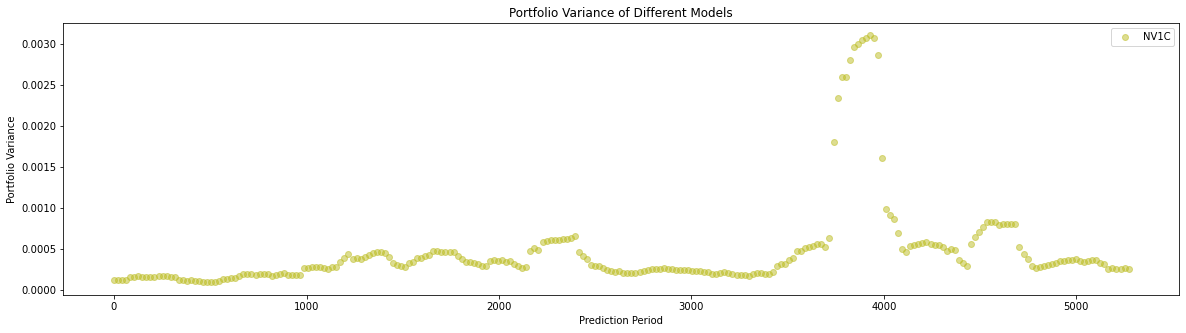

In [160]:
time_period = np.arange(0,(len(df)-250-21)+1,21)

plt.figure(figsize=(20,5))
plt.title('Portfolio Variance of Different Models')
plt.xlabel('Prediction Period') 
plt.ylabel('Portfolio Variance') 
plt.scatter(time_period, variance_pre, color='tab:olive', label='NV1C', alpha=0.5)
# plt.plot(list(np.arange(1,253,1)), Upper_bound_variance_pre, color='tab:brown')
plt.legend(loc='upper right')

for start in np.arange(0,len(df),21):
    i = np.arange(0,len(df),21)
    print(np.shape(i))

def weight_NV1C():
    df_weight = pd.DataFrame(index=range(2), columns=range(48))
    for start in np.arange(0,len(df),21):
        new_row = weight(df,start).reshape(-1,1).T
        wi = pd.DataFrame(new_row)
        df_weight.loc[len(df_weight)] = wi
        #print(wi)
    #df_weight = df_weight[1:(len(df_weight)+1),:]
    return df_weight #which is the data frame containing the whole desired period's weight for 48 assets

df_weight = pd.DataFrame(index=range(1), columns=range(48))
#df_weight
new_row = weight(df,start).reshape(-1,1).T
#wi = pd.DataFrame(new_row)
#df_weight
#len(df_weight)
df_weight.loc[len(df_weight)] = new_row

#草稿，0 np, update each row
df_weight = np.zeros((280,48))
i = 0
while i <  len(np.arange(0,len(df),21)):
    for start in np.arange(0,len(df),21):
        wi = weight(df,start).reshape(-1,1).T
        df_weight[i] = wi
    i = i+1
    #df_weight = np.concatenate((df_weight,wi))
return df_weight

def weight_NV1C():
    df_weight = pd.DataFrame()
    for start in np.arange(0,len(df),21):
        wi = pd.DataFrame(weight(df))
        df_weight[''] = wi
    return df_weight #which is the data frame containing the whole desired period's weight for 48 assets

# Plot the changes of the weight in various time

In [172]:
#convert into pandas
df_weight = pd.DataFrame(df_weight)
#rename the dataframe
assets_names = df.columns[2:51]
#len(assets_names)
df_weight.columns = assets_names
df_weight

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1.598517e-02,1.421968e-16,9.520346e-17,5.695459e-02,4.261335e-16,8.627513e-02,2.345889e-16,1.934348e-01,2.779056e-17,6.087431e-16,...,8.162694e-02,1.199725e-16,5.565813e-03,3.149846e-16,-7.658810e-17,-3.750195e-16,-8.771505e-17,3.734719e-01,-2.031746e-16,-1.192154e-17
1,5.220573e-02,1.210790e-16,2.399609e-16,6.268912e-02,4.003062e-16,1.027934e-01,1.956895e-16,1.549160e-01,2.792257e-17,5.215670e-16,...,8.242837e-02,1.467553e-16,6.820922e-02,1.427401e-16,-6.924397e-17,-3.192737e-16,-9.476385e-17,3.710355e-01,-2.490664e-16,5.566635e-17
2,-3.009254e-17,-2.053624e-16,5.812249e-18,-3.667722e-16,-1.766644e-16,4.325248e-02,2.907559e-17,1.170384e-01,-9.196639e-17,1.682873e-16,...,1.180663e-02,-2.751293e-17,3.950831e-01,-9.218282e-17,-1.455115e-16,-2.364149e-16,-1.606027e-16,4.403657e-01,-1.748150e-16,-1.377595e-16
3,-1.155481e-17,7.744016e-17,4.173275e-17,1.376455e-01,1.782464e-16,1.887884e-17,5.479799e-17,1.031355e-01,5.529793e-19,1.021501e-16,...,3.246380e-17,9.115953e-18,1.778393e-01,-2.404141e-17,-3.991655e-17,-1.150865e-16,-7.331528e-17,5.878868e-01,-8.642991e-17,-1.032315e-17
4,4.655925e-18,3.710848e-01,8.763044e-17,1.113203e-01,1.003633e-16,4.526002e-17,1.356161e-16,1.261654e-02,-1.811259e-17,1.406755e-16,...,6.890844e-02,4.237729e-17,2.589743e-17,1.240712e-17,9.693077e-19,1.444986e-16,9.398616e-02,6.211314e-01,1.168724e-16,3.756863e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.398187e-01,-1.823486e-17,3.512271e-01,4.612871e-01,1.631882e-01,6.272025e-17,1.722080e-16,6.851155e-17,6.558137e-01,7.227646e-17,...,7.806996e-18,2.341229e-17,1.157026e-17,1.927844e-17,2.233453e-01,5.734468e-17,3.232047e-17,5.796376e-18,7.993999e-17,6.806145e-18
248,1.269936e-01,-2.058837e-17,2.594824e-01,4.780686e-01,1.879260e-01,5.090550e-17,1.343038e-16,5.132783e-17,6.196959e-01,4.614169e-17,...,1.845421e-17,2.618818e-18,-9.187298e-18,4.040880e-18,1.705468e-01,3.061494e-17,1.686839e-17,-9.346182e-18,6.581943e-17,-7.662194e-18
249,1.648599e-01,-2.662554e-06,3.445593e-01,3.869698e-01,1.970717e-01,2.167609e-05,2.635731e-05,1.838808e-05,7.102506e-01,1.055245e-05,...,9.293549e-03,2.175029e-06,3.574873e-06,1.828467e-06,1.646837e-01,1.166645e-05,6.911024e-06,-1.101539e-06,1.950776e-05,4.156014e-06
250,1.761873e-01,-6.826126e-17,3.897467e-01,4.200623e-01,2.105307e-01,-1.402249e-17,1.892560e-16,2.461872e-17,1.065807e+00,-1.250677e-16,...,-1.752434e-17,-1.170852e-16,-1.047896e-16,-7.329043e-17,-7.660956e-17,-3.467126e-17,-5.389976e-17,-7.075642e-17,8.802199e-17,-5.086656e-17


In [173]:
#adding new column which is the time period covered
value = np.arange(0,len(df_weight),1)
#len(value)
df_weight.insert(loc=0, column='Period', value=value)
df_weight = df_weight.round(6)
df_weight

,Period,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,0,0.015985,0.000000,0.000000,0.056955,0.000000,0.086275,0.000000,0.193435,0.000000,...,0.081627,0.000000,0.005566,0.000000,-0.000000,-0.000000,-0.000000,0.373472,-0.00000,-0.000000
1,1,0.052206,0.000000,0.000000,0.062689,0.000000,0.102793,0.000000,0.154916,0.000000,...,0.082428,0.000000,0.068209,0.000000,-0.000000,-0.000000,-0.000000,0.371035,-0.00000,0.000000
2,2,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.043252,0.000000,0.117038,-0.000000,...,0.011807,-0.000000,0.395083,-0.000000,-0.000000,-0.000000,-0.000000,0.440366,-0.00000,-0.000000
3,3,-0.000000,0.000000,0.000000,0.137645,0.000000,0.000000,0.000000,0.103136,0.000000,...,0.000000,0.000000,0.177839,-0.000000,-0.000000,-0.000000,-0.000000,0.587887,-0.00000,-0.000000
4,4,0.000000,0.371085,0.000000,0.111320,0.000000,0.000000,0.000000,0.012617,-0.000000,...,0.068908,0.000000,0.000000,0.000000,0.000000,0.000000,0.093986,0.621131,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,247,0.139819,-0.000000,0.351227,0.461287,0.163188,0.000000,0.000000,0.000000,0.655814,...,0.000000,0.000000,0.000000,0.000000,0.223345,0.000000,0.000000,0.000000,0.00000,0.000000
248,248,0.126994,-0.000000,0.259482,0.478069,0.187926,0.000000,0.000000,0.000000,0.619696,...,0.000000,0.000000,-0.000000,0.000000,0.170547,0.000000,0.000000,-0.000000,0.00000,-0.000000
249,249,0.164860,-0.000003,0.344559,0.386970,0.197072,0.000022,0.000026,0.000018,0.710251,...,0.009294,0.000002,0.000004,0.000002,0.164684,0.000012,0.000007,-0.000001,0.00002,0.000004
250,250,0.176187,-0.000000,0.389747,0.420062,0.210531,-0.000000,0.000000,0.000000,1.065807,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.00000,-0.000000


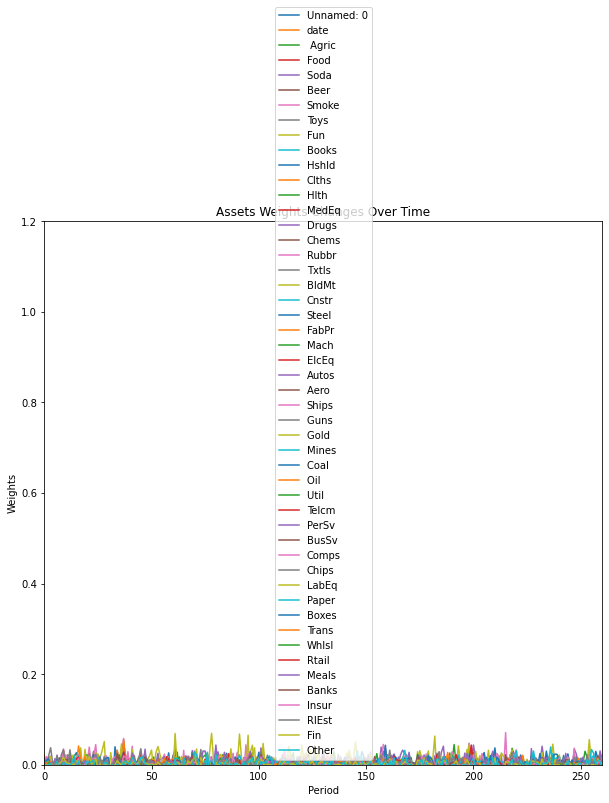

In [174]:
# set the 'Period' column as the index
df_weight = df_weight.set_index('Period')

# plot all columns at once
p = df.plot(figsize=(10, 10))
p.set_ylim([0, 1.2])
p.set_xlim([0, 260])
# set the x-axis label
plt.xlabel('Period')

# set the y-axis label
plt.ylabel('Weights')

# set the title of the graph
plt.title('Assets Weights Changes Over Time')

# show the graph
plt.show()